# 1.- Introduccion y objetivo
Este trabajo se centra en detectar según imagenes el cáncer de piel de tipo melanoma. Ésta es una de las enfermedades mas graves en dermatología, y la detección temprana a través de imágenes es clave para reducir riesgos y mejorar tratamientos. El objetivo es entrenar un modelo de clasifiación binario de imágenes capaz de distinguir entre melanoma y no melanoma, exporando como distintos hiperparametros (como la tasa de aprendizaje, numero de epocas, tamaño de batch, regularizacion, entre otros) afectan el desempeño. La metrica principal para evaluar es el F1 Score.

# Importar librerías

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pathlib import Path
import numpy as np
import copy
import random
from PIL import Image

import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from tqdm.auto import tqdm
import optuna

# 2.- EDA

## Estructura del dataset y distribucion de datos

In [21]:
# Rutas Archivos

BASE_DIR = Path(r"C:\Users\nonit\Desktop\Universidad\melanoma detection\data")

train_mel_path   = BASE_DIR / "train" / "mel"
train_nomel_path = BASE_DIR / "train" / "nomel"
val_mel_path     = BASE_DIR / "valid" / "mel"
val_nomel_path   = BASE_DIR / "valid" / "nomel"
test_path        = BASE_DIR / "test"

test_csv = pd.read_csv(BASE_DIR / "test.csv")

# Conteo
def list_images(path):
    return [f for f in path.glob("*") if f.suffix.lower() in [".jpg", ".jpeg", ".png"]]

train_mel_imgs = list_images(train_mel_path)
train_nomel_imgs = list_images(train_nomel_path)
val_mel_imgs = list_images(val_mel_path)
val_nomel_imgs = list_images(val_nomel_path)
test_imgs = list_images(test_path)

# Resumen

print("Estructura del dataset:")
print("train : imágenes para entrenamiento (subcarpetas 'mel', 'nomel')")
print("val   : imágenes para validación (subcarpetas 'mel', 'nomel')")
print("test  : imágenes para evaluación final (sin etiquetas, IDs en test.csv)")

print("\n___________ TRAIN ___________")
print(f"Melanoma    : {len(train_mel_imgs)}")
print(f"No Melanoma : {len(train_nomel_imgs)}")
print(f"Total       : {len(train_mel_imgs) + len(train_nomel_imgs)}")

print("\n___________ VALIDATION ___________")
print(f"Melanoma    : {len(val_mel_imgs)}")
print(f"No Melanoma : {len(val_nomel_imgs)}")
print(f"Total       : {len(val_mel_imgs) + len(val_nomel_imgs)}")

print("\n___________ TEST ___________")
print(f"Total imágenes en carpeta test : {len(test_imgs)}")
print(f"Total IDs en test.csv          : {len(test_csv)}")
if len(test_imgs) == len(test_csv):
    print("El número de imágenes en la carpeta test coincide con el número de IDs en test.csv.")

else:
    print("El número de imágenes en la carpeta test NO coincide con el número de IDs en test.csv.")


# Tipo de archivos

ext_train = set([img.suffix.lower() for img in train_mel_imgs + train_nomel_imgs])
ext_val = set([img.suffix.lower() for img in val_mel_imgs + val_nomel_imgs])
ext_test = set([img.suffix.lower() for img in test_imgs])

print("\n _______ FORMATOS _______")
print(f"Train: {ext_train}")
print(f"Val  : {ext_val}")
print(f"Test : {ext_test}")



Estructura del dataset:
train : imágenes para entrenamiento (subcarpetas 'mel', 'nomel')
val   : imágenes para validación (subcarpetas 'mel', 'nomel')
test  : imágenes para evaluación final (sin etiquetas, IDs en test.csv)

___________ TRAIN ___________
Melanoma    : 3644
No Melanoma : 3644
Total       : 7288

___________ VALIDATION ___________
Melanoma    : 1040
No Melanoma : 1040
Total       : 2080

___________ TEST ___________
Total imágenes en carpeta test : 1042
Total IDs en test.csv          : 1042
El número de imágenes en la carpeta test coincide con el número de IDs en test.csv.

 _______ FORMATOS _______
Train: {'.jpg'}
Val  : {'.jpg'}
Test : {'.jpg'}


## Visualización de ejemplos

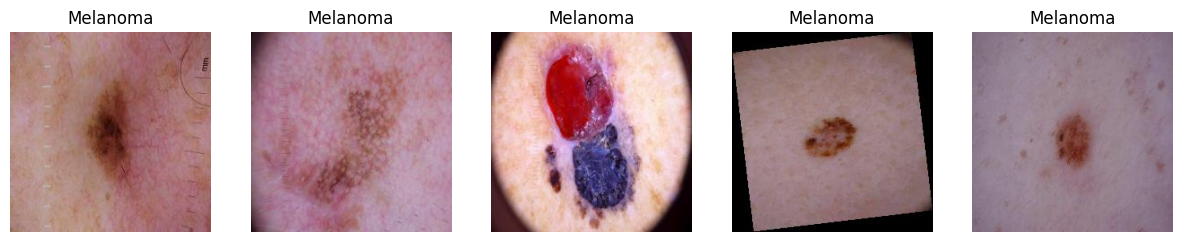

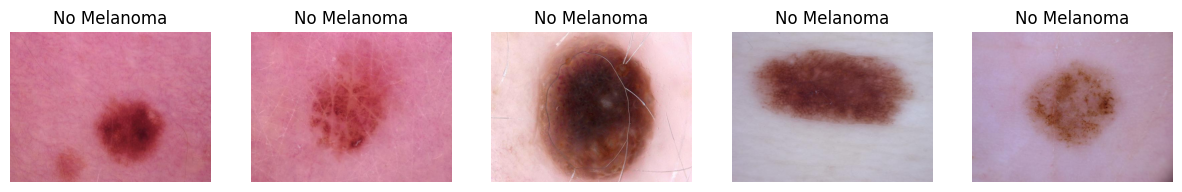

In [22]:
def show_examples(images, title, n=5):
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = random.choice(images)
        img = Image.open(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
    plt.show()

show_examples(train_mel_imgs, "Melanoma")
show_examples(train_nomel_imgs, "No Melanoma")

## Balance de clases

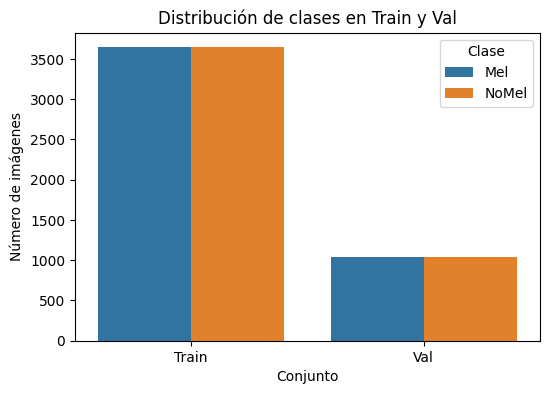

Relación Train Mel/NoMel: 1.00
Relación Val Mel/NoMel: 1.00


In [23]:
data_summary = pd.DataFrame({
    "Conjunto": ["Train", "Train", "Val", "Val"],
    "Clase": ["Mel", "NoMel", "Mel", "NoMel"],
    "Cantidad": [
        len(train_mel_imgs),
        len(train_nomel_imgs),
        len(val_mel_imgs),
        len(val_nomel_imgs)
    ]
})

plt.figure(figsize=(6,4))
sns.barplot(data=data_summary, x="Conjunto", y="Cantidad", hue="Clase")
plt.title("Distribución de clases en Train y Val")
plt.ylabel("Número de imágenes")
plt.show()

# Ratios para ver balance
ratio_train = len(train_mel_imgs) / len(train_nomel_imgs)
ratio_val = len(val_mel_imgs) / len(val_nomel_imgs)

print(f"Relación Train Mel/NoMel: {ratio_train:.2f}")
print(f"Relación Val Mel/NoMel: {ratio_val:.2f}")

## Análisis

Podemos observar que se tienen 7288 datos de training y 2080 datos de validation, ambos distribuidos equitativamente en melanoma y n melanoma (50% de cada uno). Se observa con el ejemplo visual que no todas las imagenes estan derechas, que algunas esta, por ejemplo, rotadas. No se tiene un desbalance de clases, estan balanceadas.

# 3.- Preprocesamiento

### Redimensionamiento, normalización y preparación de imágenes 

In [24]:
# REPRODUCIBILIDAD
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

IMG_SIZE = 224 # tamaño estándar. Las imagenes se convertirán a 224x224 píxeles
BATCH_SIZE = 32 # tamaño del lote. El modelo aprendera en grupos de 32 imágenes

# Data Augmentation

train_transforms = transforms.Compose([ 
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # redimensionar imagen a estandar 224x224
    transforms.RandomHorizontalFlip(p=0.5), # voltear la imagen con probabilidad 0.5
    transforms.RandomRotation(degrees=10), # rotar la imagen aleatoriamente hasta 10 grados
    transforms.ToTensor(), # convertir la imagen de formato imagen a tensor (numerico)
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # normalizar valores RGB
])

valid_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # normalizar valores RGB
])

Esto nos deja con las imagenes redimensionadas para que todas sean de 224x224, adedmás de aplicarle cambios a algunas imagenes aleatoriamente como voltearla o rotarla, para que el modelo pueda reconocer melanomas del lado que sea y angulo que sea. Además se convierte la imagen a tensor y se normalizan los valores.

### Cargar datos y organizarlos en batches

In [25]:
# ---------CREAR DATASETS---------

train_dataset = datasets.ImageFolder(BASE_DIR / "train", transform=train_transforms) #ImageFolder organiza las imagenes en base a las carpetas
val_dataset = datasets.ImageFolder(BASE_DIR / "valid", transform=valid_transforms) #Toma la carpeta donde se encuentran las imagenes y les aplica las transformaciones

# ---------CORREGIR MAPEO DE CLASES---------
correct_mapping = {'nomel': 0, 'mel': 1}

# reemplazar el mapeo de clases en los datasets
train_dataset.class_to_idx = correct_mapping
val_dataset.class_to_idx = correct_mapping
train_dataset.classes = list(correct_mapping.keys())
val_dataset.classes = list(correct_mapping.keys())

# cambiar etiquetas
new_train_samples = [(path, 1 - label) for path, label in train_dataset.samples]
new_val_samples = [(path, 1 - label) for path, label in val_dataset.samples]

train_dataset.samples = new_train_samples
val_dataset.samples = new_val_samples

# actualizar targets
train_dataset.targets = [s[1] for s in new_train_samples]
val_dataset.targets = [s[1] for s in new_val_samples]

# ---------CREAR DATALOADERS---------

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True, # mezclar las imagenes en cada epoch
    num_workers = 2 # número de subprocesos para cargar los datos mas rapidamente
)

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False, # no mezclar las imagenes en el conjunto de validacion
    num_workers = 2 # número de subprocesos para cargar los datos mas rapidamente
)

In [26]:
# verificar los tamaños de los datasets y dataloaders
print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del dataset de validación: {len(val_dataset)}")
print(f"Tamaño del dataloader de entrenamiento: {len(train_loader)}")
print(f"Tamaño del dataloader de validación: {len(val_loader)}")

Tamaño del dataset de entrenamiento: 7288
Tamaño del dataset de validación: 2080
Tamaño del dataloader de entrenamiento: 228
Tamaño del dataloader de validación: 65


In [27]:
# verificar etiquetas
class_map = train_dataset.class_to_idx
print(f"Mapeo de clases: {class_map}")

Mapeo de clases: {'nomel': 0, 'mel': 1}


# 4.- Modelos a probar

## CNN

**CNN desde cero**: Red Neuronal Convolucional (CNN), especializada en datos con estructura de malla, como imagenes. Las primeras capas detectan cosas simples como bordes, esquinas o colores, y las capas mas profundas combinan esos patrones simples para detectar características mas complejas como texturas, formas, etc.
Este modelo sirve a modo de baseliine, ya que el modelo de transfer learning deberia poder superarlo (si no lo hace algo está mal). Al implementarlo lo puedo usar de comparativa para saber si mi otro modelo esta funcionando correctamente. Además, al implementarlo desde cero, se va a especializar totalmente en detectar melanomas, sin sesgos de otros conocimientos.

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # capa convolucional 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # entra una imagen RGB (3 canales), salen 16 mapas de características
        
        # capa convolucional 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # entra 16 mapas de características, salen 32
        
        # capa convolucional 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # entra 32 mapas de características, salen 64
        
        # capa de pooling para reducir dimensionalidad (queda con lo mas importante)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        # definir clasificador
        self.fc1 = nn.Linear(64 * 28 * 28, 512) # capa totalmente conectada 1
        self.fc2 = nn.Linear(512, 1) # capa totalmente conectada 2 (salida binaria)

        self.dropout = nn.Dropout(0.5) # capa de dropout para evitar sobreajuste (apaga neuronas aleatoriamente para evitar sobreajuste)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # aplicar conv1 + ReLU + pooling
        x = self.pool(F.relu(self.conv2(x))) # aplicar conv2 + ReLU + pooling
        x = self.pool(F.relu(self.conv3(x))) # aplicar conv3 + ReLU + pooling
        
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = self.fc2(x)
        
        return x


## Transfer learning (ResNet)

**Transfer learning**: Modelo ya entrenado con un dataset enorme, que se adaptará al problema (deteccion de melanomas). Utilizaré ResNet (Residual Networks) ya que es una arquitectura conocida y potente para detectar caracteristicas visuales. Este modelo es adecuado ya que es una ventaja enorme que este pre-entrenado en deteccion de caracteristicas con una enorme cantidad de datos, por lo que aprender de los datos dados de melanomas no será dificil. Además, puede usar conocimiento de distincion de otras cosas y aplicarlo para distinguir lunares normales de melanomas. Este modelo es mas adecuado para el problema, ya que contamos con datos limitados y entrenar un modelo desde cero tiene un alto riesgo de sobreajuste.

In [29]:
def get_resnet_model(dropout_rate):
    # Cargar modelo resnet18 pre entrenado en imagenet
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # congelar parametros para no reentrenar, solo adaptar
    for param in model.parameters():
        param.requires_grad = False

    # reemplazar la capa final (fully connected)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout_rate), # Usamos el dropout que nos pasará Optuna
        nn.Linear(512, 1)          # Salida binaria final
    )
    # Descongelar solo la nueva capa clasificadora para el entrenamiento
    for param in model.fc.parameters():
        param.requires_grad = True
        
    return model

# 5.- Optimización de hiperparámetros  (NO EJECUTAR NUEVAMENTE)

**Valores tipicos learning rate:**

0.01, 0.001, 0.0001

**Batch size:**

Lotes grandes (64, 128): entrenamiento mas estable y rapido pero se puede estancar en minimos locales

Lotes pequeños (16, 32): entrenamiento mas ruidoso e inestable pero esto ayuda a encontrar mejores soluciones y generalizar mejor

**Epochs:**

Pocas = underfitting

Muchas = overfitting

**Dropout** (para combatir sobreajuste)

0.2 - 0.5


.


**ESTRATEGIA DE BUSQUEDA**

Grid search: Lento y caro, descartado ya que hay mejores opciones

Random Search: Balance entre eficiencia y rendimiento

Búsqueda Bayesiana: Aun mas eficiente, utilizaré este.

## Implementación bayesiana con optuna

ahorrar tiempo, guardar historial para no perder todo (como me pasó anteriormente), busqueda mas eficiente

In [11]:
# _____Dispositivo_____
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo para la optimización: {device}")

# ___Funciones de Entrenamiento y Evaluación___
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc="Entrenando", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def evaluate_model(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    # Usamos tqdm también aquí para una mejor visualización
    pbar = tqdm(loader, desc="Evaluando", leave=False)
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = val_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return epoch_loss, f1

# ______FUNCION OBJECTIVE DE OPTUNA______
# Define un experimento que optuna llamara N_TRIALS veces 

def objective(trial):
    # Sugerir hiperparámetros
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])

    print(f"\n--- Trial #{trial.number} ---")
    print(f"Parámetros: lr={lr:.6f}, batch_size={batch_size}, dropout={dropout:.4f}, optimizer={optimizer_name}")

    # Configurar DataLoaders, Modelo y Optimizador
    try:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    except RuntimeError:
        print(f"Error de memoria con batch_size={batch_size}. Saltando trial.")
        raise optuna.exceptions.TrialPruned()

    model = get_resnet_model(dropout_rate=dropout).to(device)
    optimizer = getattr(optim, optimizer_name)(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Bucle de entrenamiento y evaluación
    MAX_EPOCHS = 30
    PATIENCE = 4
    epochs_no_improve = 0
    best_val_f1 = 0.0

    for epoch in range(MAX_EPOCHS):
        #entrenar modelo en cada epoca
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        
        # evaluar
        val_loss, val_f1 = evaluate_model(model, val_loader, criterion, device)
        
        #imprimir resultados para monitorear
        print(f"  Epoch {epoch+1}/{MAX_EPOCHS} -> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        # Guardar el mejor F1 de este trial
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Reportar a Optuna para Pruning (poda)
        trial.report(val_f1, epoch)
        if trial.should_prune():
            print("  Trial podado por bajo rendimiento.")
            raise optuna.exceptions.TrialPruned()

        if epochs_no_improve >= PATIENCE:
            print(f"  Early Stopping.")
            break
            
    return best_val_f1

# _____ CONFIGURACIÓN Y EJECUCIÓN DEL ESTUDIO______
N_TRIALS = 30 # Ajustar
STUDY_NAME = "melanoma-resnet-simple-study"
STORAGE_NAME = f"sqlite:///{STUDY_NAME}.db"

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)

study = optuna.create_study(
    direction='maximize',
    study_name=STUDY_NAME,
    storage=STORAGE_NAME,
    load_if_exists=True,
    pruner=pruner
)

# Iniciar optimización
print(f"Iniciando/Reanudando estudio '{STUDY_NAME}'. Resultados en '{STUDY_NAME}.db'")
study.optimize(objective, n_trials=N_TRIALS)

# ___ MOSTRAR RESULTADOS ___
print("\n\nBúsqueda finalizada.")
print("Mejor trial:")
trial = study.best_trial
print(f"  F1 Score: {trial.value:.4f}")
print("  Mejores Hiperparámetros: ")
for key, value in trial.params.items():
    print(f"    - {key}: {value}")

Usando dispositivo para la optimización: cuda


[I 2025-10-15 00:37:59,553] Using an existing study with name 'melanoma-resnet-simple-study' instead of creating a new one.


Iniciando/Reanudando estudio 'melanoma-resnet-simple-study'. Resultados en 'melanoma-resnet-simple-study.db'

--- Trial #3 ---
Parámetros: lr=0.001731, batch_size=64, dropout=0.4272, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2328 | Val Loss: 0.0757 | Val F1: 0.9749


  Epoch 2/30 -> Train Loss: 0.1088 | Val Loss: 0.1401 | Val F1: 0.9505


  Epoch 3/30 -> Train Loss: 0.0800 | Val Loss: 0.0681 | Val F1: 0.9755


  Epoch 4/30 -> Train Loss: 0.0860 | Val Loss: 0.0570 | Val F1: 0.9764


  Epoch 5/30 -> Train Loss: 0.0873 | Val Loss: 0.0481 | Val F1: 0.9824


  Epoch 6/30 -> Train Loss: 0.0697 | Val Loss: 0.0711 | Val F1: 0.9755


  Epoch 7/30 -> Train Loss: 0.0572 | Val Loss: 0.0366 | Val F1: 0.9850


  Epoch 8/30 -> Train Loss: 0.0765 | Val Loss: 0.0297 | Val F1: 0.9909


  Epoch 9/30 -> Train Loss: 0.0656 | Val Loss: 0.0365 | Val F1: 0.9904


  Epoch 10/30 -> Train Loss: 0.0553 | Val Loss: 0.0400 | Val F1: 0.9867


  Epoch 11/30 -> Train Loss: 0.0512 | Val Loss: 0.0776 | Val F1: 0.9737


[I 2025-10-15 00:46:36,465] Trial 3 finished with value: 0.9908609908609909 and parameters: {'lr': 0.0017309539064341445, 'batch_size': 64, 'dropout': 0.42722576506518595, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9908609908609909.


  Epoch 12/30 -> Train Loss: 0.0463 | Val Loss: 0.0477 | Val F1: 0.9858
  Early Stopping.

--- Trial #4 ---
Parámetros: lr=0.000248, batch_size=16, dropout=0.3734, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2671 | Val Loss: 0.1228 | Val F1: 0.9534


  Epoch 2/30 -> Train Loss: 0.1473 | Val Loss: 0.0812 | Val F1: 0.9709


  Epoch 3/30 -> Train Loss: 0.1290 | Val Loss: 0.0569 | Val F1: 0.9796


  Epoch 4/30 -> Train Loss: 0.1248 | Val Loss: 0.0755 | Val F1: 0.9723


  Epoch 5/30 -> Train Loss: 0.1172 | Val Loss: 0.0572 | Val F1: 0.9815


  Epoch 6/30 -> Train Loss: 0.1349 | Val Loss: 0.0521 | Val F1: 0.9815


  Epoch 7/30 -> Train Loss: 0.1085 | Val Loss: 0.0443 | Val F1: 0.9866


  Epoch 8/30 -> Train Loss: 0.0945 | Val Loss: 0.0600 | Val F1: 0.9820


  Epoch 9/30 -> Train Loss: 0.0882 | Val Loss: 0.0436 | Val F1: 0.9862


  Epoch 10/30 -> Train Loss: 0.0908 | Val Loss: 0.0331 | Val F1: 0.9890


  Epoch 11/30 -> Train Loss: 0.0838 | Val Loss: 0.0702 | Val F1: 0.9751


  Epoch 12/30 -> Train Loss: 0.0736 | Val Loss: 0.0682 | Val F1: 0.9760


  Epoch 13/30 -> Train Loss: 0.0919 | Val Loss: 0.0313 | Val F1: 0.9879


[I 2025-10-15 00:56:57,637] Trial 4 finished with value: 0.9889793962625779 and parameters: {'lr': 0.00024773701950497445, 'batch_size': 16, 'dropout': 0.373407215561667, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9908609908609909.


  Epoch 14/30 -> Train Loss: 0.0940 | Val Loss: 0.0498 | Val F1: 0.9830
  Early Stopping.

--- Trial #5 ---
Parámetros: lr=0.002035, batch_size=32, dropout=0.2500, optimizer=SGD


  Epoch 1/30 -> Train Loss: 0.5876 | Val Loss: 0.5079 | Val F1: 0.8358


  Epoch 2/30 -> Train Loss: 0.4407 | Val Loss: 0.4046 | Val F1: 0.8562


  Epoch 3/30 -> Train Loss: 0.3496 | Val Loss: 0.3250 | Val F1: 0.8869


  Epoch 4/30 -> Train Loss: 0.2891 | Val Loss: 0.2547 | Val F1: 0.9225


  Epoch 5/30 -> Train Loss: 0.2485 | Val Loss: 0.2253 | Val F1: 0.9294


  Epoch 6/30 -> Train Loss: 0.2226 | Val Loss: 0.1961 | Val F1: 0.9374


  Epoch 7/30 -> Train Loss: 0.2042 | Val Loss: 0.1793 | Val F1: 0.9421


  Epoch 8/30 -> Train Loss: 0.1848 | Val Loss: 0.1506 | Val F1: 0.9526


  Epoch 9/30 -> Train Loss: 0.1712 | Val Loss: 0.1425 | Val F1: 0.9530


  Epoch 10/30 -> Train Loss: 0.1570 | Val Loss: 0.1282 | Val F1: 0.9579


  Epoch 11/30 -> Train Loss: 0.1523 | Val Loss: 0.1125 | Val F1: 0.9632


  Epoch 12/30 -> Train Loss: 0.1455 | Val Loss: 0.1159 | Val F1: 0.9596


  Epoch 13/30 -> Train Loss: 0.1438 | Val Loss: 0.1084 | Val F1: 0.9637


  Epoch 14/30 -> Train Loss: 0.1358 | Val Loss: 0.1031 | Val F1: 0.9668


  Epoch 15/30 -> Train Loss: 0.1263 | Val Loss: 0.0938 | Val F1: 0.9673


  Epoch 16/30 -> Train Loss: 0.1203 | Val Loss: 0.0931 | Val F1: 0.9673


  Epoch 17/30 -> Train Loss: 0.1169 | Val Loss: 0.0886 | Val F1: 0.9723


  Epoch 18/30 -> Train Loss: 0.1135 | Val Loss: 0.0758 | Val F1: 0.9763


  Epoch 19/30 -> Train Loss: 0.1119 | Val Loss: 0.0865 | Val F1: 0.9677


  Epoch 20/30 -> Train Loss: 0.1085 | Val Loss: 0.0759 | Val F1: 0.9736


  Epoch 21/30 -> Train Loss: 0.1050 | Val Loss: 0.0737 | Val F1: 0.9750


[I 2025-10-15 01:12:45,501] Trial 5 finished with value: 0.9763481551561022 and parameters: {'lr': 0.002035380012040536, 'batch_size': 32, 'dropout': 0.24996427872560872, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.9908609908609909.


  Epoch 22/30 -> Train Loss: 0.1028 | Val Loss: 0.0800 | Val F1: 0.9723
  Early Stopping.

--- Trial #6 ---
Parámetros: lr=0.000067, batch_size=32, dropout=0.4545, optimizer=SGD


  Epoch 1/30 -> Train Loss: 0.7047 | Val Loss: 0.7012 | Val F1: 0.2505


  Epoch 2/30 -> Train Loss: 0.6896 | Val Loss: 0.6911 | Val F1: 0.4452


  Epoch 3/30 -> Train Loss: 0.6808 | Val Loss: 0.6801 | Val F1: 0.5684


  Epoch 4/30 -> Train Loss: 0.6721 | Val Loss: 0.6730 | Val F1: 0.6398


  Epoch 5/30 -> Train Loss: 0.6638 | Val Loss: 0.6670 | Val F1: 0.6696


  Epoch 6/30 -> Train Loss: 0.6551 | Val Loss: 0.6583 | Val F1: 0.7047


  Epoch 7/30 -> Train Loss: 0.6503 | Val Loss: 0.6521 | Val F1: 0.7201


  Epoch 8/30 -> Train Loss: 0.6422 | Val Loss: 0.6467 | Val F1: 0.7356


  Epoch 9/30 -> Train Loss: 0.6350 | Val Loss: 0.6399 | Val F1: 0.7437


  Epoch 10/30 -> Train Loss: 0.6256 | Val Loss: 0.6337 | Val F1: 0.7559


  Epoch 11/30 -> Train Loss: 0.6204 | Val Loss: 0.6282 | Val F1: 0.7632


  Epoch 12/30 -> Train Loss: 0.6142 | Val Loss: 0.6225 | Val F1: 0.7763


  Epoch 13/30 -> Train Loss: 0.6081 | Val Loss: 0.6154 | Val F1: 0.7751


  Epoch 14/30 -> Train Loss: 0.6028 | Val Loss: 0.6089 | Val F1: 0.7881


  Epoch 15/30 -> Train Loss: 0.5963 | Val Loss: 0.6019 | Val F1: 0.7881


  Epoch 16/30 -> Train Loss: 0.5909 | Val Loss: 0.5964 | Val F1: 0.7957


  Epoch 17/30 -> Train Loss: 0.5842 | Val Loss: 0.5929 | Val F1: 0.7974


  Epoch 18/30 -> Train Loss: 0.5774 | Val Loss: 0.5862 | Val F1: 0.7976


  Epoch 19/30 -> Train Loss: 0.5711 | Val Loss: 0.5854 | Val F1: 0.7869


  Epoch 20/30 -> Train Loss: 0.5675 | Val Loss: 0.5744 | Val F1: 0.8099


  Epoch 21/30 -> Train Loss: 0.5627 | Val Loss: 0.5706 | Val F1: 0.8076


  Epoch 22/30 -> Train Loss: 0.5546 | Val Loss: 0.5680 | Val F1: 0.7997


  Epoch 23/30 -> Train Loss: 0.5467 | Val Loss: 0.5629 | Val F1: 0.8019


  Epoch 24/30 -> Train Loss: 0.5468 | Val Loss: 0.5533 | Val F1: 0.8180


  Epoch 25/30 -> Train Loss: 0.5405 | Val Loss: 0.5489 | Val F1: 0.8215


  Epoch 26/30 -> Train Loss: 0.5389 | Val Loss: 0.5449 | Val F1: 0.8109


  Epoch 27/30 -> Train Loss: 0.5305 | Val Loss: 0.5385 | Val F1: 0.8171


  Epoch 28/30 -> Train Loss: 0.5256 | Val Loss: 0.5360 | Val F1: 0.8190


[I 2025-10-15 01:33:36,929] Trial 6 finished with value: 0.821486268174475 and parameters: {'lr': 6.744485951187862e-05, 'batch_size': 32, 'dropout': 0.45452969019890765, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.9908609908609909.


  Epoch 29/30 -> Train Loss: 0.5211 | Val Loss: 0.5328 | Val F1: 0.8169
  Early Stopping.

--- Trial #7 ---
Parámetros: lr=0.000069, batch_size=32, dropout=0.2805, optimizer=SGD


  Epoch 1/30 -> Train Loss: 0.6803 | Val Loss: 0.6696 | Val F1: 0.5047


  Epoch 2/30 -> Train Loss: 0.6675 | Val Loss: 0.6616 | Val F1: 0.6471


  Epoch 3/30 -> Train Loss: 0.6586 | Val Loss: 0.6540 | Val F1: 0.7102


  Epoch 4/30 -> Train Loss: 0.6509 | Val Loss: 0.6468 | Val F1: 0.7415


  Epoch 5/30 -> Train Loss: 0.6437 | Val Loss: 0.6397 | Val F1: 0.7659


  Epoch 6/30 -> Train Loss: 0.6366 | Val Loss: 0.6330 | Val F1: 0.7675


  Epoch 7/30 -> Train Loss: 0.6324 | Val Loss: 0.6291 | Val F1: 0.7819


  Epoch 8/30 -> Train Loss: 0.6238 | Val Loss: 0.6233 | Val F1: 0.7772


  Epoch 9/30 -> Train Loss: 0.6170 | Val Loss: 0.6139 | Val F1: 0.7942


  Epoch 10/30 -> Train Loss: 0.6118 | Val Loss: 0.6104 | Val F1: 0.7948


  Epoch 11/30 -> Train Loss: 0.6024 | Val Loss: 0.6032 | Val F1: 0.7985


  Epoch 12/30 -> Train Loss: 0.5976 | Val Loss: 0.5960 | Val F1: 0.8053


  Epoch 13/30 -> Train Loss: 0.5892 | Val Loss: 0.5907 | Val F1: 0.8034


  Epoch 14/30 -> Train Loss: 0.5871 | Val Loss: 0.5893 | Val F1: 0.8011


  Epoch 15/30 -> Train Loss: 0.5805 | Val Loss: 0.5803 | Val F1: 0.8096


  Epoch 16/30 -> Train Loss: 0.5730 | Val Loss: 0.5741 | Val F1: 0.8105


  Epoch 17/30 -> Train Loss: 0.5653 | Val Loss: 0.5726 | Val F1: 0.8066


  Epoch 18/30 -> Train Loss: 0.5610 | Val Loss: 0.5630 | Val F1: 0.8088


  Epoch 19/30 -> Train Loss: 0.5538 | Val Loss: 0.5613 | Val F1: 0.8096


  Epoch 20/30 -> Train Loss: 0.5493 | Val Loss: 0.5558 | Val F1: 0.8116


  Epoch 21/30 -> Train Loss: 0.5452 | Val Loss: 0.5488 | Val F1: 0.8245


  Epoch 22/30 -> Train Loss: 0.5410 | Val Loss: 0.5440 | Val F1: 0.8176


  Epoch 23/30 -> Train Loss: 0.5333 | Val Loss: 0.5376 | Val F1: 0.8230


  Epoch 24/30 -> Train Loss: 0.5283 | Val Loss: 0.5366 | Val F1: 0.8197


  Epoch 25/30 -> Train Loss: 0.5233 | Val Loss: 0.5281 | Val F1: 0.8257


  Epoch 26/30 -> Train Loss: 0.5180 | Val Loss: 0.5269 | Val F1: 0.8208


  Epoch 27/30 -> Train Loss: 0.5120 | Val Loss: 0.5187 | Val F1: 0.8268


  Epoch 28/30 -> Train Loss: 0.5092 | Val Loss: 0.5170 | Val F1: 0.8239


  Epoch 29/30 -> Train Loss: 0.5032 | Val Loss: 0.5126 | Val F1: 0.8284


[I 2025-10-15 01:55:01,496] Trial 7 finished with value: 0.8410981697171381 and parameters: {'lr': 6.910092788830054e-05, 'batch_size': 32, 'dropout': 0.2805311981740364, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.9908609908609909.


  Epoch 30/30 -> Train Loss: 0.4986 | Val Loss: 0.4993 | Val F1: 0.8411

--- Trial #8 ---
Parámetros: lr=0.000024, batch_size=16, dropout=0.4594, optimizer=SGD


  Epoch 1/30 -> Train Loss: 0.7276 | Val Loss: 0.7011 | Val F1: 0.6542


  Epoch 2/30 -> Train Loss: 0.7090 | Val Loss: 0.6878 | Val F1: 0.6612


  Epoch 3/30 -> Train Loss: 0.6981 | Val Loss: 0.6850 | Val F1: 0.6500


[I 2025-10-15 01:57:56,909] Trial 8 pruned.                  


  Epoch 4/30 -> Train Loss: 0.6914 | Val Loss: 0.6773 | Val F1: 0.6622
  Trial podado por bajo rendimiento.

--- Trial #9 ---
Parámetros: lr=0.000057, batch_size=16, dropout=0.1257, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.3720 | Val Loss: 0.2268 | Val F1: 0.9228


  Epoch 2/30 -> Train Loss: 0.2099 | Val Loss: 0.1434 | Val F1: 0.9534


  Epoch 3/30 -> Train Loss: 0.1631 | Val Loss: 0.0808 | Val F1: 0.9785


  Epoch 4/30 -> Train Loss: 0.1409 | Val Loss: 0.0743 | Val F1: 0.9801


  Epoch 5/30 -> Train Loss: 0.1405 | Val Loss: 0.0615 | Val F1: 0.9828


  Epoch 6/30 -> Train Loss: 0.1141 | Val Loss: 0.0639 | Val F1: 0.9810


  Epoch 7/30 -> Train Loss: 0.1062 | Val Loss: 0.0948 | Val F1: 0.9655


  Epoch 8/30 -> Train Loss: 0.1086 | Val Loss: 0.0488 | Val F1: 0.9866


  Epoch 9/30 -> Train Loss: 0.1036 | Val Loss: 0.0552 | Val F1: 0.9805


  Epoch 10/30 -> Train Loss: 0.1090 | Val Loss: 0.0602 | Val F1: 0.9801


  Epoch 11/30 -> Train Loss: 0.0904 | Val Loss: 0.0493 | Val F1: 0.9862


[I 2025-10-15 02:06:44,391] Trial 9 finished with value: 0.9866412213740458 and parameters: {'lr': 5.660309314555519e-05, 'batch_size': 16, 'dropout': 0.1256554082002082, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9908609908609909.


  Epoch 12/30 -> Train Loss: 0.0876 | Val Loss: 0.0493 | Val F1: 0.9852
  Early Stopping.

--- Trial #10 ---
Parámetros: lr=0.002257, batch_size=32, dropout=0.3073, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2149 | Val Loss: 0.0593 | Val F1: 0.9777


  Epoch 2/30 -> Train Loss: 0.1199 | Val Loss: 0.2609 | Val F1: 0.9075


  Epoch 3/30 -> Train Loss: 0.1025 | Val Loss: 0.0574 | Val F1: 0.9792


  Epoch 4/30 -> Train Loss: 0.0922 | Val Loss: 0.0730 | Val F1: 0.9760


  Epoch 5/30 -> Train Loss: 0.0967 | Val Loss: 0.0495 | Val F1: 0.9834


  Epoch 6/30 -> Train Loss: 0.0977 | Val Loss: 0.0513 | Val F1: 0.9825


  Epoch 7/30 -> Train Loss: 0.0746 | Val Loss: 0.0823 | Val F1: 0.9719


  Epoch 8/30 -> Train Loss: 0.0806 | Val Loss: 0.0453 | Val F1: 0.9829


  Epoch 9/30 -> Train Loss: 0.0824 | Val Loss: 0.0313 | Val F1: 0.9885


  Epoch 10/30 -> Train Loss: 0.0714 | Val Loss: 0.0627 | Val F1: 0.9788


  Epoch 11/30 -> Train Loss: 0.0668 | Val Loss: 0.0482 | Val F1: 0.9844


  Epoch 12/30 -> Train Loss: 0.0811 | Val Loss: 0.0648 | Val F1: 0.9806


  Epoch 13/30 -> Train Loss: 0.0575 | Val Loss: 0.0325 | Val F1: 0.9914


  Epoch 14/30 -> Train Loss: 0.0629 | Val Loss: 0.0597 | Val F1: 0.9788


  Epoch 15/30 -> Train Loss: 0.0681 | Val Loss: 0.0404 | Val F1: 0.9876


  Epoch 16/30 -> Train Loss: 0.0638 | Val Loss: 0.0251 | Val F1: 0.9913


[I 2025-10-15 02:18:53,499] Trial 10 finished with value: 0.9914040114613181 and parameters: {'lr': 0.0022573976247665796, 'batch_size': 32, 'dropout': 0.3073176550328725, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.9914040114613181.


  Epoch 17/30 -> Train Loss: 0.0537 | Val Loss: 0.0367 | Val F1: 0.9886
  Early Stopping.

--- Trial #11 ---
Parámetros: lr=0.000145, batch_size=64, dropout=0.3189, optimizer=SGD


  Epoch 1/30 -> Train Loss: 0.6986 | Val Loss: 0.6759 | Val F1: 0.6573


  Epoch 2/30 -> Train Loss: 0.6878 | Val Loss: 0.6685 | Val F1: 0.6608


  Epoch 3/30 -> Train Loss: 0.6787 | Val Loss: 0.6622 | Val F1: 0.6906


[I 2025-10-15 02:21:42,889] Trial 11 pruned.                 


  Epoch 4/30 -> Train Loss: 0.6740 | Val Loss: 0.6565 | Val F1: 0.7186
  Trial podado por bajo rendimiento.

--- Trial #12 ---
Parámetros: lr=0.002711, batch_size=64, dropout=0.4599, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2267 | Val Loss: 0.0753 | Val F1: 0.9740


  Epoch 2/30 -> Train Loss: 0.0944 | Val Loss: 0.0616 | Val F1: 0.9755


  Epoch 3/30 -> Train Loss: 0.0964 | Val Loss: 0.0541 | Val F1: 0.9819


  Epoch 4/30 -> Train Loss: 0.1040 | Val Loss: 0.0784 | Val F1: 0.9732


  Epoch 5/30 -> Train Loss: 0.0944 | Val Loss: 0.0363 | Val F1: 0.9895


  Epoch 6/30 -> Train Loss: 0.0862 | Val Loss: 0.0590 | Val F1: 0.9792


  Epoch 7/30 -> Train Loss: 0.0595 | Val Loss: 0.0354 | Val F1: 0.9895


  Epoch 8/30 -> Train Loss: 0.0798 | Val Loss: 0.0669 | Val F1: 0.9760


  Epoch 9/30 -> Train Loss: 0.0492 | Val Loss: 0.0466 | Val F1: 0.9829


  Epoch 10/30 -> Train Loss: 0.0704 | Val Loss: 0.0316 | Val F1: 0.9919


  Epoch 11/30 -> Train Loss: 0.0662 | Val Loss: 0.0348 | Val F1: 0.9895


  Epoch 12/30 -> Train Loss: 0.0618 | Val Loss: 0.0321 | Val F1: 0.9885


  Epoch 13/30 -> Train Loss: 0.0591 | Val Loss: 0.0553 | Val F1: 0.9820


[I 2025-10-15 02:31:35,316] Trial 12 finished with value: 0.9918621349928195 and parameters: {'lr': 0.002710915223924604, 'batch_size': 64, 'dropout': 0.4598864130535597, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.9918621349928195.


  Epoch 14/30 -> Train Loss: 0.0581 | Val Loss: 0.0387 | Val F1: 0.9876
  Early Stopping.

--- Trial #13 ---
Parámetros: lr=0.008324, batch_size=64, dropout=0.1836, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.3780 | Val Loss: 0.1513 | Val F1: 0.9465


  Epoch 2/30 -> Train Loss: 0.1015 | Val Loss: 0.0443 | Val F1: 0.9861


  Epoch 3/30 -> Train Loss: 0.1120 | Val Loss: 0.1785 | Val F1: 0.9385


  Epoch 4/30 -> Train Loss: 0.1198 | Val Loss: 0.0479 | Val F1: 0.9824


  Epoch 5/30 -> Train Loss: 0.1027 | Val Loss: 0.0622 | Val F1: 0.9746


[I 2025-10-15 02:35:50,429] Trial 13 finished with value: 0.9860911270983214 and parameters: {'lr': 0.008323926807202288, 'batch_size': 64, 'dropout': 0.18364253722695706, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.9918621349928195.


  Epoch 6/30 -> Train Loss: 0.1094 | Val Loss: 0.1285 | Val F1: 0.9487
  Early Stopping.

--- Trial #14 ---
Parámetros: lr=0.001147, batch_size=32, dropout=0.3669, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2100 | Val Loss: 0.1332 | Val F1: 0.9518


  Epoch 2/30 -> Train Loss: 0.1361 | Val Loss: 0.0820 | Val F1: 0.9695


  Epoch 3/30 -> Train Loss: 0.0925 | Val Loss: 0.0439 | Val F1: 0.9847


  Epoch 4/30 -> Train Loss: 0.0941 | Val Loss: 0.0800 | Val F1: 0.9696


  Epoch 5/30 -> Train Loss: 0.0962 | Val Loss: 0.1091 | Val F1: 0.9571


  Epoch 6/30 -> Train Loss: 0.0876 | Val Loss: 0.0410 | Val F1: 0.9857


  Epoch 7/30 -> Train Loss: 0.0840 | Val Loss: 0.0773 | Val F1: 0.9746


  Epoch 8/30 -> Train Loss: 0.0813 | Val Loss: 0.0920 | Val F1: 0.9674


  Epoch 9/30 -> Train Loss: 0.0709 | Val Loss: 0.0335 | Val F1: 0.9914


  Epoch 10/30 -> Train Loss: 0.0622 | Val Loss: 0.0337 | Val F1: 0.9899


  Epoch 11/30 -> Train Loss: 0.0611 | Val Loss: 0.0384 | Val F1: 0.9871


  Epoch 12/30 -> Train Loss: 0.0634 | Val Loss: 0.0312 | Val F1: 0.9909


[I 2025-10-15 02:45:07,015] Trial 14 finished with value: 0.9913710450623202 and parameters: {'lr': 0.001146722184273571, 'batch_size': 32, 'dropout': 0.36690163293916755, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.9918621349928195.


  Epoch 13/30 -> Train Loss: 0.0721 | Val Loss: 0.0335 | Val F1: 0.9900
  Early Stopping.

--- Trial #15 ---
Parámetros: lr=0.006941, batch_size=64, dropout=0.2284, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.4489 | Val Loss: 0.0933 | Val F1: 0.9739


  Epoch 2/30 -> Train Loss: 0.1191 | Val Loss: 0.1067 | Val F1: 0.9632


  Epoch 3/30 -> Train Loss: 0.0850 | Val Loss: 0.1560 | Val F1: 0.9496


  Epoch 4/30 -> Train Loss: 0.1196 | Val Loss: 0.0643 | Val F1: 0.9774


  Epoch 5/30 -> Train Loss: 0.0781 | Val Loss: 0.0488 | Val F1: 0.9834


  Epoch 6/30 -> Train Loss: 0.0587 | Val Loss: 0.0751 | Val F1: 0.9728


  Epoch 7/30 -> Train Loss: 0.0830 | Val Loss: 0.0974 | Val F1: 0.9656


  Epoch 8/30 -> Train Loss: 0.0622 | Val Loss: 0.0818 | Val F1: 0.9692


[I 2025-10-15 02:51:26,969] Trial 15 finished with value: 0.9833729216152018 and parameters: {'lr': 0.0069408932753036185, 'batch_size': 64, 'dropout': 0.22842595715604835, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.9918621349928195.


  Epoch 9/30 -> Train Loss: 0.0746 | Val Loss: 0.0714 | Val F1: 0.9751
  Early Stopping.

--- Trial #16 ---
Parámetros: lr=0.000659, batch_size=64, dropout=0.4957, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2523 | Val Loss: 0.1603 | Val F1: 0.9410


  Epoch 2/30 -> Train Loss: 0.1205 | Val Loss: 0.0732 | Val F1: 0.9723


  Epoch 3/30 -> Train Loss: 0.0899 | Val Loss: 0.0568 | Val F1: 0.9792


  Epoch 4/30 -> Train Loss: 0.0816 | Val Loss: 0.1101 | Val F1: 0.9575


[I 2025-10-15 02:54:58,914] Trial 16 pruned.                 


  Epoch 5/30 -> Train Loss: 0.0677 | Val Loss: 0.0993 | Val F1: 0.9652
  Trial podado por bajo rendimiento.

--- Trial #17 ---
Parámetros: lr=0.003435, batch_size=32, dropout=0.3696, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2385 | Val Loss: 0.0669 | Val F1: 0.9777


  Epoch 2/30 -> Train Loss: 0.1327 | Val Loss: 0.1593 | Val F1: 0.9359


  Epoch 3/30 -> Train Loss: 0.1270 | Val Loss: 0.1577 | Val F1: 0.9394


  Epoch 4/30 -> Train Loss: 0.1088 | Val Loss: 0.0409 | Val F1: 0.9855


  Epoch 5/30 -> Train Loss: 0.1091 | Val Loss: 0.0537 | Val F1: 0.9806


  Epoch 6/30 -> Train Loss: 0.1150 | Val Loss: 0.1147 | Val F1: 0.9602


  Epoch 7/30 -> Train Loss: 0.0845 | Val Loss: 0.0410 | Val F1: 0.9857


  Epoch 8/30 -> Train Loss: 0.0882 | Val Loss: 0.0312 | Val F1: 0.9914


  Epoch 9/30 -> Train Loss: 0.0981 | Val Loss: 0.0557 | Val F1: 0.9801


  Epoch 10/30 -> Train Loss: 0.0848 | Val Loss: 0.0471 | Val F1: 0.9862


  Epoch 11/30 -> Train Loss: 0.0816 | Val Loss: 0.0544 | Val F1: 0.9811


[I 2025-10-15 03:03:33,106] Trial 17 finished with value: 0.9913544668587896 and parameters: {'lr': 0.0034353351817127745, 'batch_size': 32, 'dropout': 0.36955416713780687, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.9918621349928195.


  Epoch 12/30 -> Train Loss: 0.0697 | Val Loss: 0.0403 | Val F1: 0.9881
  Early Stopping.

--- Trial #18 ---
Parámetros: lr=0.000566, batch_size=32, dropout=0.3271, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2416 | Val Loss: 0.1707 | Val F1: 0.9338


  Epoch 2/30 -> Train Loss: 0.1219 | Val Loss: 0.0572 | Val F1: 0.9815


  Epoch 3/30 -> Train Loss: 0.0964 | Val Loss: 0.0488 | Val F1: 0.9792


  Epoch 4/30 -> Train Loss: 0.1017 | Val Loss: 0.0767 | Val F1: 0.9696


  Epoch 5/30 -> Train Loss: 0.0853 | Val Loss: 0.0409 | Val F1: 0.9845


  Epoch 6/30 -> Train Loss: 0.0817 | Val Loss: 0.0530 | Val F1: 0.9820


  Epoch 7/30 -> Train Loss: 0.0731 | Val Loss: 0.0481 | Val F1: 0.9839


  Epoch 8/30 -> Train Loss: 0.0658 | Val Loss: 0.0634 | Val F1: 0.9783


  Epoch 9/30 -> Train Loss: 0.0666 | Val Loss: 0.0368 | Val F1: 0.9885


  Epoch 10/30 -> Train Loss: 0.0701 | Val Loss: 0.0356 | Val F1: 0.9845


  Epoch 11/30 -> Train Loss: 0.0712 | Val Loss: 0.0283 | Val F1: 0.9923


  Epoch 12/30 -> Train Loss: 0.0586 | Val Loss: 0.0394 | Val F1: 0.9876


  Epoch 13/30 -> Train Loss: 0.0546 | Val Loss: 0.0254 | Val F1: 0.9928


  Epoch 14/30 -> Train Loss: 0.0580 | Val Loss: 0.0304 | Val F1: 0.9914


  Epoch 15/30 -> Train Loss: 0.0650 | Val Loss: 0.0289 | Val F1: 0.9919


  Epoch 16/30 -> Train Loss: 0.0545 | Val Loss: 0.0491 | Val F1: 0.9844


[I 2025-10-15 03:15:42,306] Trial 18 finished with value: 0.9928057553956835 and parameters: {'lr': 0.0005660819161062671, 'batch_size': 32, 'dropout': 0.32705349747076246, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 17/30 -> Train Loss: 0.0538 | Val Loss: 0.0426 | Val F1: 0.9844
  Early Stopping.

--- Trial #19 ---
Parámetros: lr=0.000492, batch_size=64, dropout=0.4074, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2682 | Val Loss: 0.1245 | Val F1: 0.9564


  Epoch 2/30 -> Train Loss: 0.1219 | Val Loss: 0.0937 | Val F1: 0.9641


  Epoch 3/30 -> Train Loss: 0.0984 | Val Loss: 0.0580 | Val F1: 0.9810


  Epoch 4/30 -> Train Loss: 0.0912 | Val Loss: 0.1119 | Val F1: 0.9607


[I 2025-10-15 03:19:14,027] Trial 19 pruned.                 


  Epoch 5/30 -> Train Loss: 0.0754 | Val Loss: 0.0980 | Val F1: 0.9637
  Trial podado por bajo rendimiento.

--- Trial #20 ---
Parámetros: lr=0.000753, batch_size=32, dropout=0.3404, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2019 | Val Loss: 0.0941 | Val F1: 0.9646


  Epoch 2/30 -> Train Loss: 0.1243 | Val Loss: 0.0660 | Val F1: 0.9755


  Epoch 3/30 -> Train Loss: 0.0930 | Val Loss: 0.1549 | Val F1: 0.9433


  Epoch 4/30 -> Train Loss: 0.1042 | Val Loss: 0.0604 | Val F1: 0.9787


[I 2025-10-15 03:22:49,160] Trial 20 pruned.                 


  Epoch 5/30 -> Train Loss: 0.0921 | Val Loss: 0.0586 | Val F1: 0.9773
  Trial podado por bajo rendimiento.

--- Trial #21 ---
Parámetros: lr=0.003840, batch_size=64, dropout=0.4925, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.3111 | Val Loss: 0.0987 | Val F1: 0.9628


  Epoch 2/30 -> Train Loss: 0.1309 | Val Loss: 0.1889 | Val F1: 0.9314


  Epoch 3/30 -> Train Loss: 0.1119 | Val Loss: 0.0437 | Val F1: 0.9856


  Epoch 4/30 -> Train Loss: 0.0970 | Val Loss: 0.0585 | Val F1: 0.9778


  Epoch 5/30 -> Train Loss: 0.0835 | Val Loss: 0.1418 | Val F1: 0.9476


  Epoch 6/30 -> Train Loss: 0.1053 | Val Loss: 0.0608 | Val F1: 0.9778


[I 2025-10-15 03:27:46,745] Trial 21 finished with value: 0.9855769230769231 and parameters: {'lr': 0.0038401693574031254, 'batch_size': 64, 'dropout': 0.4924923426218455, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 7/30 -> Train Loss: 0.0857 | Val Loss: 0.0467 | Val F1: 0.9820
  Early Stopping.

--- Trial #22 ---
Parámetros: lr=0.000291, batch_size=16, dropout=0.1859, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2652 | Val Loss: 0.1152 | Val F1: 0.9614


  Epoch 2/30 -> Train Loss: 0.1386 | Val Loss: 0.0690 | Val F1: 0.9727


  Epoch 3/30 -> Train Loss: 0.1277 | Val Loss: 0.0496 | Val F1: 0.9832


  Epoch 4/30 -> Train Loss: 0.1138 | Val Loss: 0.0563 | Val F1: 0.9829


  Epoch 5/30 -> Train Loss: 0.1223 | Val Loss: 0.0445 | Val F1: 0.9850


  Epoch 6/30 -> Train Loss: 0.0889 | Val Loss: 0.0665 | Val F1: 0.9783


  Epoch 7/30 -> Train Loss: 0.0991 | Val Loss: 0.0414 | Val F1: 0.9857


  Epoch 8/30 -> Train Loss: 0.0945 | Val Loss: 0.0408 | Val F1: 0.9842


  Epoch 9/30 -> Train Loss: 0.0868 | Val Loss: 0.0475 | Val F1: 0.9843


  Epoch 10/30 -> Train Loss: 0.0915 | Val Loss: 0.0295 | Val F1: 0.9899


  Epoch 11/30 -> Train Loss: 0.0851 | Val Loss: 0.0287 | Val F1: 0.9909


  Epoch 12/30 -> Train Loss: 0.0784 | Val Loss: 0.0246 | Val F1: 0.9914


  Epoch 13/30 -> Train Loss: 0.0748 | Val Loss: 0.0511 | Val F1: 0.9820


  Epoch 14/30 -> Train Loss: 0.0729 | Val Loss: 0.0298 | Val F1: 0.9914


  Epoch 15/30 -> Train Loss: 0.0684 | Val Loss: 0.0300 | Val F1: 0.9895


  Epoch 16/30 -> Train Loss: 0.0807 | Val Loss: 0.0260 | Val F1: 0.9914


  Epoch 17/30 -> Train Loss: 0.0716 | Val Loss: 0.0305 | Val F1: 0.9909


[I 2025-10-15 03:40:59,274] Trial 22 finished with value: 0.9913957934990439 and parameters: {'lr': 0.00029117177435673754, 'batch_size': 16, 'dropout': 0.1859304338795875, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 18/30 -> Train Loss: 0.0652 | Val Loss: 0.0377 | Val F1: 0.9886
  Early Stopping.

--- Trial #23 ---
Parámetros: lr=0.000013, batch_size=64, dropout=0.4111, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.6168 | Val Loss: 0.5530 | Val F1: 0.8421


  Epoch 2/30 -> Train Loss: 0.5131 | Val Loss: 0.4792 | Val F1: 0.8490


  Epoch 3/30 -> Train Loss: 0.4345 | Val Loss: 0.4198 | Val F1: 0.8629


[I 2025-10-15 03:43:48,428] Trial 23 pruned.                 


  Epoch 4/30 -> Train Loss: 0.3856 | Val Loss: 0.3728 | Val F1: 0.8785
  Trial podado por bajo rendimiento.

--- Trial #24 ---
Parámetros: lr=0.002879, batch_size=32, dropout=0.2887, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2340 | Val Loss: 0.0609 | Val F1: 0.9763


  Epoch 2/30 -> Train Loss: 0.1250 | Val Loss: 0.0991 | Val F1: 0.9664


  Epoch 3/30 -> Train Loss: 0.1335 | Val Loss: 0.0713 | Val F1: 0.9732


  Epoch 4/30 -> Train Loss: 0.0916 | Val Loss: 0.0820 | Val F1: 0.9687


  Epoch 5/30 -> Train Loss: 0.0929 | Val Loss: 0.0398 | Val F1: 0.9866


  Epoch 6/30 -> Train Loss: 0.0764 | Val Loss: 0.0613 | Val F1: 0.9774


  Epoch 7/30 -> Train Loss: 0.0709 | Val Loss: 0.0307 | Val F1: 0.9904


  Epoch 8/30 -> Train Loss: 0.0944 | Val Loss: 0.0301 | Val F1: 0.9899


  Epoch 9/30 -> Train Loss: 0.0836 | Val Loss: 0.0395 | Val F1: 0.9867


  Epoch 10/30 -> Train Loss: 0.0702 | Val Loss: 0.0835 | Val F1: 0.9711


[I 2025-10-15 03:51:39,653] Trial 24 finished with value: 0.9904030710172744 and parameters: {'lr': 0.002878957521171148, 'batch_size': 32, 'dropout': 0.2887174739927736, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 11/30 -> Train Loss: 0.0792 | Val Loss: 0.0480 | Val F1: 0.9858
  Early Stopping.

--- Trial #25 ---
Parámetros: lr=0.001150, batch_size=32, dropout=0.3366, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2245 | Val Loss: 0.0589 | Val F1: 0.9824


  Epoch 2/30 -> Train Loss: 0.1029 | Val Loss: 0.0634 | Val F1: 0.9783


  Epoch 3/30 -> Train Loss: 0.1008 | Val Loss: 0.0471 | Val F1: 0.9852


  Epoch 4/30 -> Train Loss: 0.0823 | Val Loss: 0.0835 | Val F1: 0.9714


  Epoch 5/30 -> Train Loss: 0.1127 | Val Loss: 0.0485 | Val F1: 0.9857


  Epoch 6/30 -> Train Loss: 0.0835 | Val Loss: 0.0362 | Val F1: 0.9871


  Epoch 7/30 -> Train Loss: 0.0750 | Val Loss: 0.0555 | Val F1: 0.9815


  Epoch 8/30 -> Train Loss: 0.0697 | Val Loss: 0.0536 | Val F1: 0.9811


  Epoch 9/30 -> Train Loss: 0.0650 | Val Loss: 0.0544 | Val F1: 0.9792


[I 2025-10-15 03:58:47,519] Trial 25 finished with value: 0.9871121718377088 and parameters: {'lr': 0.0011499443803486378, 'batch_size': 32, 'dropout': 0.33661444313277644, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 10/30 -> Train Loss: 0.0606 | Val Loss: 0.0719 | Val F1: 0.9742
  Early Stopping.

--- Trial #26 ---
Parámetros: lr=0.005952, batch_size=32, dropout=0.2624, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2576 | Val Loss: 0.0708 | Val F1: 0.9759


  Epoch 2/30 -> Train Loss: 0.1338 | Val Loss: 0.1347 | Val F1: 0.9505


  Epoch 3/30 -> Train Loss: 0.1197 | Val Loss: 0.0854 | Val F1: 0.9634


  Epoch 4/30 -> Train Loss: 0.1131 | Val Loss: 0.0704 | Val F1: 0.9751


  Epoch 5/30 -> Train Loss: 0.0881 | Val Loss: 0.0426 | Val F1: 0.9866


  Epoch 6/30 -> Train Loss: 0.0932 | Val Loss: 0.0469 | Val F1: 0.9848


  Epoch 7/30 -> Train Loss: 0.0840 | Val Loss: 0.1061 | Val F1: 0.9629


  Epoch 8/30 -> Train Loss: 0.0942 | Val Loss: 0.0873 | Val F1: 0.9687


  Epoch 9/30 -> Train Loss: 0.0856 | Val Loss: 0.0341 | Val F1: 0.9895


  Epoch 10/30 -> Train Loss: 0.0900 | Val Loss: 0.1202 | Val F1: 0.9638


  Epoch 11/30 -> Train Loss: 0.0944 | Val Loss: 0.0598 | Val F1: 0.9834


  Epoch 12/30 -> Train Loss: 0.0870 | Val Loss: 0.1311 | Val F1: 0.9537


[I 2025-10-15 04:08:04,959] Trial 26 finished with value: 0.9894534995206136 and parameters: {'lr': 0.005952345961441007, 'batch_size': 32, 'dropout': 0.2624177664498013, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 13/30 -> Train Loss: 0.0876 | Val Loss: 0.0692 | Val F1: 0.9769
  Early Stopping.

--- Trial #27 ---
Parámetros: lr=0.001342, batch_size=32, dropout=0.1951, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.1932 | Val Loss: 0.0670 | Val F1: 0.9759


  Epoch 2/30 -> Train Loss: 0.1368 | Val Loss: 0.1806 | Val F1: 0.9386


  Epoch 3/30 -> Train Loss: 0.1140 | Val Loss: 0.0615 | Val F1: 0.9782


  Epoch 4/30 -> Train Loss: 0.0754 | Val Loss: 0.0622 | Val F1: 0.9792


[I 2025-10-15 04:11:39,079] Trial 27 pruned.                 


  Epoch 5/30 -> Train Loss: 0.1144 | Val Loss: 0.0707 | Val F1: 0.9760
  Trial podado por bajo rendimiento.

--- Trial #28 ---
Parámetros: lr=0.000449, batch_size=32, dropout=0.1166, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2246 | Val Loss: 0.0713 | Val F1: 0.9761


  Epoch 2/30 -> Train Loss: 0.1164 | Val Loss: 0.0627 | Val F1: 0.9764


  Epoch 3/30 -> Train Loss: 0.0958 | Val Loss: 0.0447 | Val F1: 0.9866


  Epoch 4/30 -> Train Loss: 0.0957 | Val Loss: 0.0507 | Val F1: 0.9833


  Epoch 5/30 -> Train Loss: 0.0831 | Val Loss: 0.0467 | Val F1: 0.9848


  Epoch 6/30 -> Train Loss: 0.0682 | Val Loss: 0.1236 | Val F1: 0.9580


[I 2025-10-15 04:16:39,203] Trial 28 finished with value: 0.9866028708133971 and parameters: {'lr': 0.0004492086293390729, 'batch_size': 32, 'dropout': 0.11664425626343078, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 7/30 -> Train Loss: 0.0737 | Val Loss: 0.0603 | Val F1: 0.9802
  Early Stopping.

--- Trial #29 ---
Parámetros: lr=0.002462, batch_size=32, dropout=0.3113, optimizer=SGD


  Epoch 1/30 -> Train Loss: 0.5897 | Val Loss: 0.4959 | Val F1: 0.8336


  Epoch 2/30 -> Train Loss: 0.4228 | Val Loss: 0.4014 | Val F1: 0.8370


  Epoch 3/30 -> Train Loss: 0.3277 | Val Loss: 0.2799 | Val F1: 0.9118


[I 2025-10-15 04:19:30,527] Trial 29 pruned.                 


  Epoch 4/30 -> Train Loss: 0.2713 | Val Loss: 0.2316 | Val F1: 0.9285
  Trial podado por bajo rendimiento.

--- Trial #30 ---
Parámetros: lr=0.005275, batch_size=32, dropout=0.2137, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2684 | Val Loss: 0.0800 | Val F1: 0.9704


  Epoch 2/30 -> Train Loss: 0.1285 | Val Loss: 0.1990 | Val F1: 0.9290


  Epoch 3/30 -> Train Loss: 0.1226 | Val Loss: 0.0951 | Val F1: 0.9651


[I 2025-10-15 04:22:22,043] Trial 30 pruned.                 


  Epoch 4/30 -> Train Loss: 0.1322 | Val Loss: 0.2469 | Val F1: 0.9127
  Trial podado por bajo rendimiento.

--- Trial #31 ---
Parámetros: lr=0.000143, batch_size=16, dropout=0.3868, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.3033 | Val Loss: 0.1305 | Val F1: 0.9603


  Epoch 2/30 -> Train Loss: 0.1643 | Val Loss: 0.0763 | Val F1: 0.9754


  Epoch 3/30 -> Train Loss: 0.1330 | Val Loss: 0.0706 | Val F1: 0.9745


  Epoch 4/30 -> Train Loss: 0.1357 | Val Loss: 0.0907 | Val F1: 0.9655


[I 2025-10-15 04:26:02,249] Trial 31 pruned.                 


  Epoch 5/30 -> Train Loss: 0.1012 | Val Loss: 0.0610 | Val F1: 0.9768
  Trial podado por bajo rendimiento.

--- Trial #32 ---
Parámetros: lr=0.001603, batch_size=64, dropout=0.4441, optimizer=Adam


  Epoch 1/30 -> Train Loss: 0.2317 | Val Loss: 0.0934 | Val F1: 0.9637


  Epoch 2/30 -> Train Loss: 0.1123 | Val Loss: 0.0645 | Val F1: 0.9746


  Epoch 3/30 -> Train Loss: 0.0845 | Val Loss: 0.0489 | Val F1: 0.9805


  Epoch 4/30 -> Train Loss: 0.0935 | Val Loss: 0.0400 | Val F1: 0.9884


  Epoch 5/30 -> Train Loss: 0.0895 | Val Loss: 0.0559 | Val F1: 0.9810


  Epoch 6/30 -> Train Loss: 0.0742 | Val Loss: 0.0429 | Val F1: 0.9876


  Epoch 7/30 -> Train Loss: 0.0646 | Val Loss: 0.0484 | Val F1: 0.9829


[I 2025-10-15 04:31:39,371] Trial 32 finished with value: 0.9884281581485053 and parameters: {'lr': 0.0016034131660529023, 'batch_size': 64, 'dropout': 0.44406946767376254, 'optimizer': 'Adam'}. Best is trial 18 with value: 0.9928057553956835.


  Epoch 8/30 -> Train Loss: 0.0556 | Val Loss: 0.0514 | Val F1: 0.9829
  Early Stopping.


Búsqueda finalizada.
Mejor trial:
  F1 Score: 0.9928
  Mejores Hiperparámetros: 
    - lr: 0.0005660819161062671
    - batch_size: 32
    - dropout: 0.32705349747076246
    - optimizer: Adam


## Imprimir resultados

In [ ]:
# Nombre del estudio y almacenamiento
STUDY_NAME = "melanoma-resnet-simple-study"
STORAGE_NAME = f"sqlite:///{STUDY_NAME}.db"

# Cargar el estudio completo desde la base de datos
loaded_study = optuna.load_study(
    study_name=STUDY_NAME,
    storage=STORAGE_NAME
)

# Mostrar el mejor resultado
best_trial = loaded_study.best_trial
print("--- Mejor Resultado Encontrado ---")
print(f"F1 Score: {best_trial.value:.4f}")
print("Mejores Hiperparámetros:")
for key, value in best_trial.params.items():
    print(f"  - {key}: {value}")

# Tabla con mejores experimentos
print("\n--- Tabla con los 10 Mejores Experimentos ---")
results_df = loaded_study.trials_dataframe()
# Ordenar por el valor (F1-Score) de mayor a menor
print(results_df.sort_values(by="value", ascending=False).head(10))

--- Mejor Resultado Encontrado ---
F1 Score: 0.9928
Mejores Hiperparámetros:
  - lr: 0.0005660819161062671
  - batch_size: 32
  - dropout: 0.32705349747076246
  - optimizer: Adam

--- Tabla con los 10 Mejores Experimentos ---
    number     value             datetime_start          datetime_complete  \
18      18  0.992806 2025-10-15 03:03:33.113660 2025-10-15 03:15:42.291333   
12      12  0.991862 2025-10-15 02:21:42.894861 2025-10-15 02:31:35.304818   
10      10  0.991404 2025-10-15 02:06:44.396267 2025-10-15 02:18:53.484075   
22      22  0.991396 2025-10-15 03:27:46.752331 2025-10-15 03:40:59.256229   
14      14  0.991371 2025-10-15 02:35:50.434751 2025-10-15 02:45:07.003035   
17      17  0.991354 2025-10-15 02:54:58.919506 2025-10-15 03:03:33.092833   
3        3  0.990861 2025-10-15 00:37:59.569817 2025-10-15 00:46:36.449344   
24      24  0.990403 2025-10-15 03:43:48.434857 2025-10-15 03:51:39.641869   
26      26  0.989453 2025-10-15 03:58:47.523659 2025-10-15 04:08:04.9472

# 6.- Entrenamiento

Se copian los mejores valores de lr, optimizer, dropout, etc, y se inicializa una nueva instancia de get_resnet_model, junto con el optimizador y el scheduler, usando los mejores parametros encontrados en la etapa anterior.

Luego se entrenará este modelo durante un numero mas o menos grande de epocas (50), utilizando early stopping. Se guardaran los pesos de la epoca en que se alcanzo el f1 score mas alto. Se usará ese modelo como modelo final.

Seguiré usando la funcion de perdida anterior (nn.BCEWithLogitsLoss). Se usará el optimizador que optuna determino como el mejor, junto con la tasa de aprendizaje tambienn ganadora. El scheduler reducira el learning rate si el modelo se estanca y el val loss no mejora. 

Contra el sobreajuste se usa data augmentation, regularizacion (dropout que optuna haya encontrado como el mejor) y early stopping.

In [30]:
# Funciones sacadas de la celda de busqueda de hiperparámetros, ya que no se ejecutara nuevamente

# _____Dispositivo_____
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo para la optimización: {device}")

# ___Funciones de Entrenamiento y Evaluación___
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc="Entrenando", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def evaluate_model(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    # Usamos tqdm también aquí para una mejor visualización
    pbar = tqdm(loader, desc="Evaluando", leave=False)
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = val_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return epoch_loss, f1

Usando dispositivo para la optimización: cuda



Entrenando modelo final con los mejores hiperparámetros encontrados:
{'lr': 0.0005660819161062671, 'optimizer': 'Adam', 'batch_size': 32, 'dropout': 0.32705349747076246}

===== Época 1/50 =====



Resultados Época 1:
  Train -> Loss: 0.2256, F1: 0.9744
  Val   -> Loss: 0.0847, F1: 0.9690
Nuevo mejor F1 en validación: 0.9690. Modelo guardado.

===== Época 2/50 =====



Resultados Época 2:
  Train -> Loss: 0.1179, F1: 0.9820
  Val   -> Loss: 0.0662, F1: 0.9755
Nuevo mejor F1 en validación: 0.9755. Modelo guardado.

===== Época 3/50 =====



Resultados Época 3:
  Train -> Loss: 0.0786, F1: 0.9709
  Val   -> Loss: 0.0452, F1: 0.9851
Nuevo mejor F1 en validación: 0.9851. Modelo guardado.

===== Época 4/50 =====



Resultados Época 4:
  Train -> Loss: 0.1007, F1: 0.9582
  Val   -> Loss: 0.0428, F1: 0.9865
Nuevo mejor F1 en validación: 0.9865. Modelo guardado.

===== Época 5/50 =====



Resultados Época 5:
  Train -> Loss: 0.0846, F1: 0.9793
  Val   -> Loss: 0.0400, F1: 0.9866
Nuevo mejor F1 en validación: 0.9866. Modelo guardado.

===== Época 6/50 =====



Resultados Época 6:
  Train -> Loss: 0.0764, F1: 0.9651
  Val   -> Loss: 0.1302, F1: 0.9550
No hubo mejora en F1. Paciencia: 1/7

===== Época 7/50 =====



Resultados Época 7:
  Train -> Loss: 0.0868, F1: 0.9870
  Val   -> Loss: 0.0453, F1: 0.9824
No hubo mejora en F1. Paciencia: 2/7

===== Época 8/50 =====



Resultados Época 8:
  Train -> Loss: 0.0818, F1: 0.9890
  Val   -> Loss: 0.0393, F1: 0.9862
No hubo mejora en F1. Paciencia: 3/7

===== Época 9/50 =====



Resultados Época 9:
  Train -> Loss: 0.0588, F1: 0.9860
  Val   -> Loss: 0.0348, F1: 0.9890
Nuevo mejor F1 en validación: 0.9890. Modelo guardado.

===== Época 10/50 =====



Resultados Época 10:
  Train -> Loss: 0.0494, F1: 0.9893
  Val   -> Loss: 0.0604, F1: 0.9788
No hubo mejora en F1. Paciencia: 1/7

===== Época 11/50 =====



Resultados Época 11:
  Train -> Loss: 0.0479, F1: 0.9888
  Val   -> Loss: 0.0461, F1: 0.9848
No hubo mejora en F1. Paciencia: 2/7

===== Época 12/50 =====



Resultados Época 12:
  Train -> Loss: 0.0515, F1: 0.9902
  Val   -> Loss: 0.0507, F1: 0.9829
No hubo mejora en F1. Paciencia: 3/7

===== Época 13/50 =====



Resultados Época 13:
  Train -> Loss: 0.0571, F1: 0.9913
  Val   -> Loss: 0.0374, F1: 0.9885
No hubo mejora en F1. Paciencia: 4/7

===== Época 14/50 =====



Resultados Época 14:
  Train -> Loss: 0.0535, F1: 0.9911
  Val   -> Loss: 0.0340, F1: 0.9895
Nuevo mejor F1 en validación: 0.9895. Modelo guardado.

===== Época 15/50 =====



Resultados Época 15:
  Train -> Loss: 0.0468, F1: 0.9891
  Val   -> Loss: 0.0501, F1: 0.9824
No hubo mejora en F1. Paciencia: 1/7

===== Época 16/50 =====



Resultados Época 16:
  Train -> Loss: 0.0473, F1: 0.9905
  Val   -> Loss: 0.0375, F1: 0.9881
No hubo mejora en F1. Paciencia: 2/7

===== Época 17/50 =====



Resultados Época 17:
  Train -> Loss: 0.0503, F1: 0.9888
  Val   -> Loss: 0.0364, F1: 0.9890
No hubo mejora en F1. Paciencia: 3/7

===== Época 18/50 =====



Resultados Época 18:
  Train -> Loss: 0.0462, F1: 0.9893
  Val   -> Loss: 0.0376, F1: 0.9876
No hubo mejora en F1. Paciencia: 4/7

===== Época 19/50 =====



Resultados Época 19:
  Train -> Loss: 0.0491, F1: 0.9915
  Val   -> Loss: 0.0423, F1: 0.9843
No hubo mejora en F1. Paciencia: 5/7

===== Época 20/50 =====



Resultados Época 20:
  Train -> Loss: 0.0456, F1: 0.9912
  Val   -> Loss: 0.0409, F1: 0.9857
No hubo mejora en F1. Paciencia: 6/7

===== Época 21/50 =====



Resultados Época 21:
  Train -> Loss: 0.0567, F1: 0.9906
  Val   -> Loss: 0.0346, F1: 0.9904
Nuevo mejor F1 en validación: 0.9904. Modelo guardado.

===== Época 22/50 =====



Resultados Época 22:
  Train -> Loss: 0.0514, F1: 0.9909
  Val   -> Loss: 0.0340, F1: 0.9890
No hubo mejora en F1. Paciencia: 1/7

===== Época 23/50 =====



Resultados Época 23:
  Train -> Loss: 0.0498, F1: 0.9895
  Val   -> Loss: 0.0311, F1: 0.9919
Nuevo mejor F1 en validación: 0.9919. Modelo guardado.

===== Época 24/50 =====



Resultados Época 24:
  Train -> Loss: 0.0484, F1: 0.9896
  Val   -> Loss: 0.0393, F1: 0.9862
No hubo mejora en F1. Paciencia: 1/7

===== Época 25/50 =====



Resultados Época 25:
  Train -> Loss: 0.0476, F1: 0.9901
  Val   -> Loss: 0.0508, F1: 0.9834
No hubo mejora en F1. Paciencia: 2/7

===== Época 26/50 =====



Resultados Época 26:
  Train -> Loss: 0.0543, F1: 0.9908
  Val   -> Loss: 0.0428, F1: 0.9853
No hubo mejora en F1. Paciencia: 3/7

===== Época 27/50 =====



Resultados Época 27:
  Train -> Loss: 0.0591, F1: 0.9912
  Val   -> Loss: 0.0414, F1: 0.9862
No hubo mejora en F1. Paciencia: 4/7

===== Época 28/50 =====



Resultados Época 28:
  Train -> Loss: 0.0490, F1: 0.9904
  Val   -> Loss: 0.0430, F1: 0.9848
No hubo mejora en F1. Paciencia: 5/7

===== Época 29/50 =====



Resultados Época 29:
  Train -> Loss: 0.0521, F1: 0.9892
  Val   -> Loss: 0.0390, F1: 0.9876
No hubo mejora en F1. Paciencia: 6/7

===== Época 30/50 =====



Resultados Época 30:
  Train -> Loss: 0.0452, F1: 0.9900
  Val   -> Loss: 0.0482, F1: 0.9838
No hubo mejora en F1. Paciencia: 7/7
Early Stopping en epoch 30.

Entrenamiento finalizado. Mejor modelo guardado en 'final_best_model.pth'


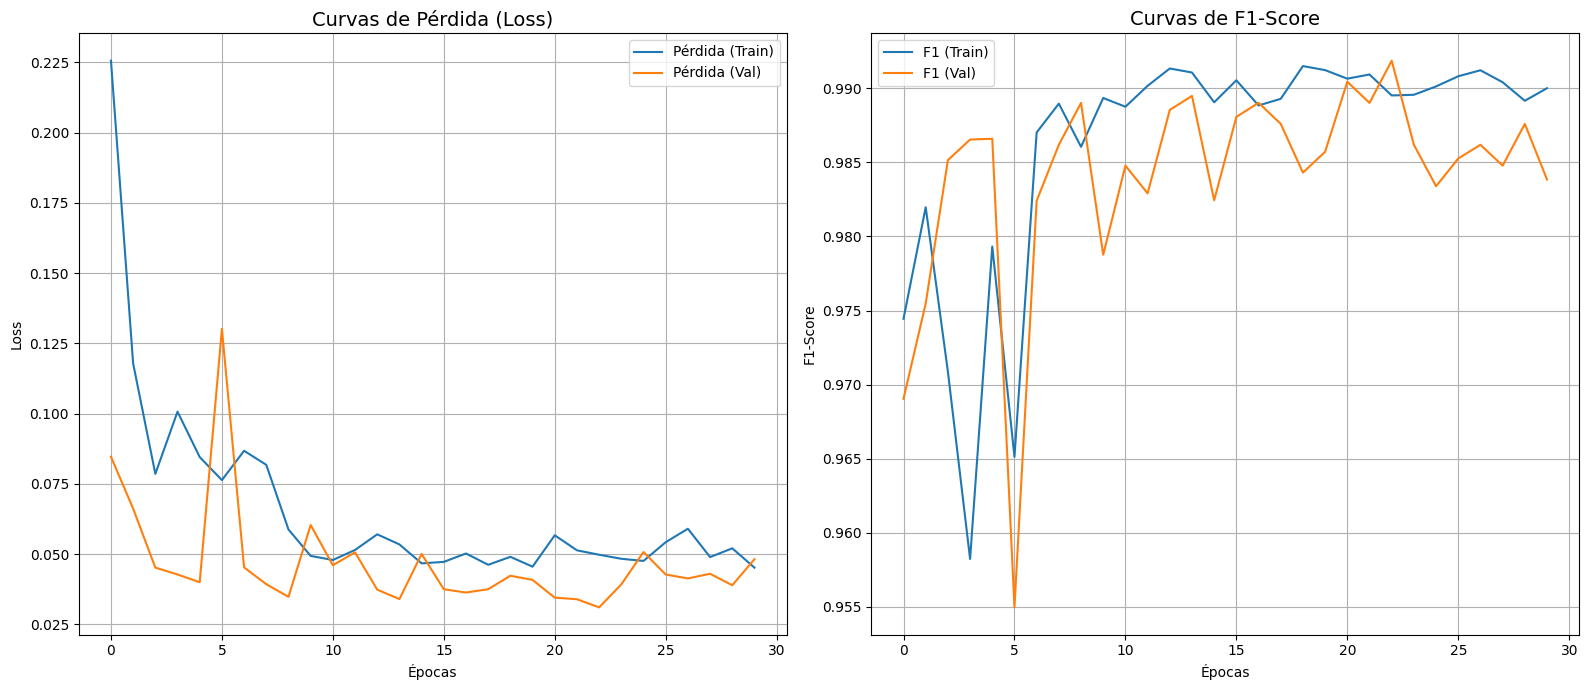

In [17]:
# _____ENTRENAMIENTO FINAL CON MEJORES HIPERPARÁMETROS______
# Copiar mejores hiperparámetros

best_params = {
    'lr': 0.0005660819161062671,
    'optimizer': 'Adam',
    'batch_size': 32,
    'dropout': 0.32705349747076246
}

print("\nEntrenando modelo final con los mejores hiperparámetros encontrados:")
print(best_params)

# Configurar DataLoaders, Modelo y Optimizador con los mejores hiperparámetros
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=2)

# Pasar mejor dropout a get_resnet_model
model = get_resnet_model(dropout_rate=best_params['dropout']).to(device)
criterion = nn.BCEWithLogitsLoss()

optimizer_class = getattr(optim, best_params['optimizer'])
optimizer = optimizer_class(filter(lambda p: p.requires_grad, model.parameters()), lr=best_params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# Bucle de entrenamiento con Early Stopping
MAX_EPOCHS = 50
PATIENCE = 7
epochs_no_improve = 0
best_val_f1 = 0.0
best_model_weights = None

history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(MAX_EPOCHS):
    print(f"\n===== Época {epoch+1}/{MAX_EPOCHS} =====")
    
    # Entrenar y evaluar
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Evaluar en ambos sets para métricas consistentes
    _, train_f1 = evaluate_model(model, train_loader, criterion, device)
    val_loss, val_f1 = evaluate_model(model, val_loader, criterion, device)
    
    print(f"\nResultados Época {epoch+1}:")
    print(f"  Train -> Loss: {train_loss:.4f}, F1: {train_f1:.4f}")
    print(f"  Val   -> Loss: {val_loss:.4f}, F1: {val_f1:.4f}")
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    # El scheduler actualiza el learning rate basándose en el F1-Score de validación
    scheduler.step(val_f1)

    # Lógica de Early Stopping y guardado del mejor modelo
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"Nuevo mejor F1 en validación: {best_val_f1:.4f}. Modelo guardado.")
    else:
        epochs_no_improve += 1
        print(f"No hubo mejora en F1. Paciencia: {epochs_no_improve}/{PATIENCE}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early Stopping en epoch {epoch+1}.")
        break

# Cargar el mejor modelo y guardarlo en disco
model.load_state_dict(best_model_weights)
torch.save(model.state_dict(), 'final_best_model.pth')
print("\nEntrenamiento finalizado. Mejor modelo guardado en 'final_best_model.pth'")

# ________ CURVAS DE ENTRENAMIENTO ________
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida (Train)')
plt.plot(history['val_loss'], label='Pérdida (Val)')
plt.title('Curvas de Pérdida (Loss)', fontsize=14)
plt.xlabel('Épocas'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='F1 (Train)')
plt.plot(history['val_f1'], label='F1 (Val)')
plt.title('Curvas de F1-Score', fontsize=14)
plt.xlabel('Épocas'); plt.ylabel('F1-Score'); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# 7.- Evaluación

### Cargar modelo

In [38]:
# _____CARGAR MODELO ENTRENADO______
# Cargar mejor Dropout encontrado en la búsqueda de hiperparámetros y recrear arquitectura
best_dropout = 0.32705349747076246
model = get_resnet_model(dropout_rate=best_dropout)

# Cargar pesos guardados
model_path = 'final_best_model.pth'
model.load_state_dict(torch.load(model_path))

# Mover modelo a dispositivo
model = model.to(device)

# Poner modelo en modo evaluación
model.eval()

print("Modelo cargado y listo para evaluación.")

Modelo cargado y listo para evaluación.


### Generar Predicciones

In [39]:
# Funcion para obtener todas las predicciones
def get_all_preds(model, loader, device):
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Obteniendo predicciones"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_probs)

print("Predicciones generadas con éxito.")

Predicciones generadas con éxito.


### Encontrar umbral óptimo

In [41]:
y_true, y_probs = get_all_preds(model, val_loader, device)

precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * recall[:-1] * precision[:-1] / (recall[:-1] + precision[:-1] + 1e-9)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"\nSe encontró el umbral óptimo: {best_threshold:.4f} (con un F1-Score de {best_f1:.4f})")

Obteniendo predicciones: 100%|██████████| 65/65 [00:19<00:00,  3.39it/s]



Se encontró el umbral óptimo: 0.6946 (con un F1-Score de 0.9928)


### Predicciones finales y reporte de clasificación


____ Reporte de Clasificación con Umbral Optimizado ____
              precision    recall  f1-score   support

   NoMel (0)       0.99      0.99      0.99      1040
     Mel (1)       0.99      0.99      0.99      1040

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080


===== Matriz de Confusión con Umbral Optimizado =====


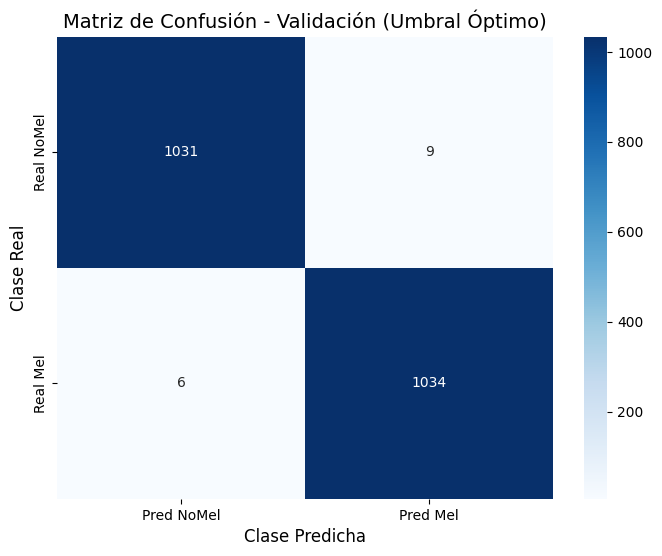

In [44]:
y_preds_optimal = (y_probs >= best_threshold).astype(int)

print("\n____ Reporte de Clasificación con Umbral Optimizado ____")
target_names = ['NoMel (0)', 'Mel (1)']
print(classification_report(y_true, y_preds_optimal, target_names=target_names))

print("\n===== Matriz de Confusión con Umbral Optimizado =====")
cm = confusion_matrix(y_true, y_preds_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred NoMel', 'Pred Mel'], 
            yticklabels=['Real NoMel', 'Real Mel'])
plt.title('Matriz de Confusión - Validación (Umbral Óptimo)', fontsize=14)
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.show()

### Analisis de errores


Usando el umbral óptimo, el modelo cometió 15 errores:
  - Falsos Positivos (NoMel -> Mel): 9
  - Falsos Negativos (Mel -> NoMel): 6

Ejemplos de Falsos Negativos (los más críticos):


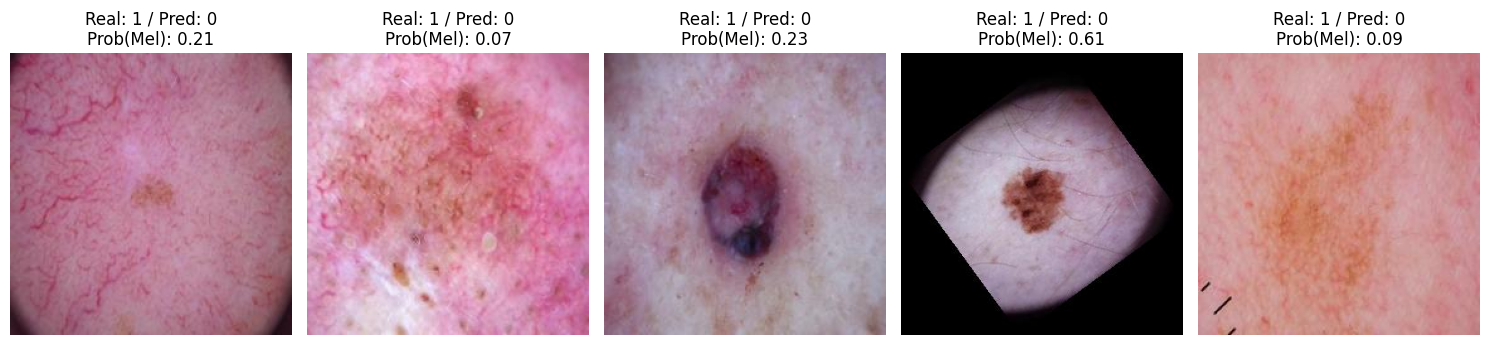


Ejemplos de Falsos Positivos:


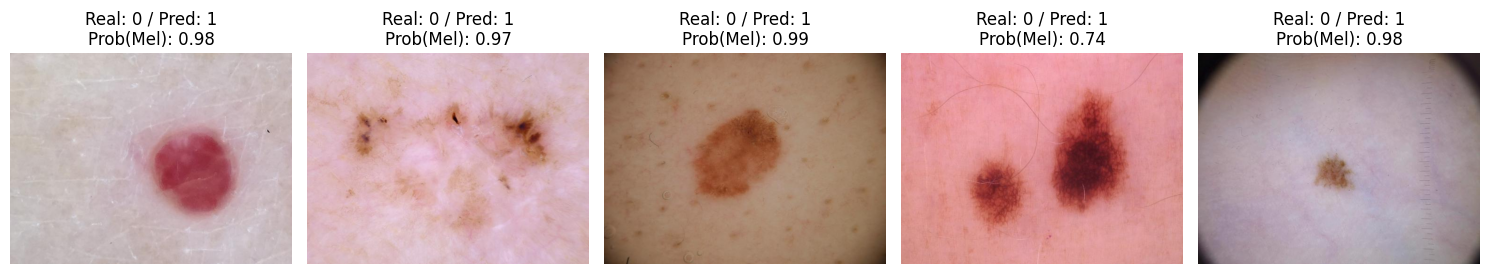

In [45]:
# Encontrar y Separar Errores con el Umbral Óptimo
fp_idx = np.where((y_preds_optimal == 1) & (y_true == 0))[0] # Falsos Positivos
fn_idx = np.where((y_preds_optimal == 0) & (y_true == 1))[0] # Falsos Negativos

print(f"\nUsando el umbral óptimo, el modelo cometió {len(fp_idx) + len(fn_idx)} errores:")
print(f"  - Falsos Positivos (NoMel -> Mel): {len(fp_idx)}")
print(f"  - Falsos Negativos (Mel -> NoMel): {len(fn_idx)}")

# Función para Mostrar Imágenes de Error
def show_misclassified_images(indices, title, max_images=5):
    if len(indices) == 0:
        print(f"\n{title}: ¡No se encontraron ejemplos!")
        return
    
    print(f"\n{title}:")
    num_images_to_show = min(len(indices), max_images)
    plt.figure(figsize=(15, 4))
    
    for i, idx in enumerate(indices[:num_images_to_show]):
        img_path, true_label = val_dataset.samples[idx]
        pred_prob = y_probs[idx]
        img = Image.open(img_path)
        
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(img)
        plt.title(f"Real: {true_label} / Pred: {y_preds_optimal[idx]}\nProb(Mel): {pred_prob:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar Ejemplos de Errores
show_misclassified_images(fn_idx, "Ejemplos de Falsos Negativos (los más críticos)")
show_misclassified_images(fp_idx, "Ejemplos de Falsos Positivos")

# 8.- Visualización de resultados

# 9.- Generación de submission